In [1]:
import geometric_kernels.torch 
import torch 
from torch import Tensor 
from mdgp.kernels import GeometricMaternKernel
from torch.func import jacfwd, vmap
from geometric_kernels.spaces import Hypersphere
from torch import nn 
from mdgp.utils import sphere_uniform_grid
from gpytorch.lazy import LazyEvaluatedKernelTensor

torch.set_default_dtype(torch.float64)

INFO: Using numpy backend


In [60]:
space = Hypersphere(2)
# NOTE need to figure out how to support likelihood samples 
base_kernel = GeometricMaternKernel(space, batch_shape=None, num_eigenfunctions=20)

In [61]:
def flatten_matrix_valued_kernel(K: Tensor | LazyEvaluatedKernelTensor) -> Tensor: 
    """
    K: (..., N, M, D, D)
    return: (..., N * D, M * D)
    """
    if isinstance(K, LazyEvaluatedKernelTensor): 
        K = K.evaluate()
    return torch.cat(
        [torch.cat([block for block in row_of_blocks.unbind(-3)], dim=-1)
         for row_of_blocks in K.unbind(-4)], dim=-2
    )


def unflatten_matrix_valued_kernel(K: Tensor, d: int = 2) -> Tensor: 
    """
    K: (..., N * D, M * D)
    return: (..., N, M, D, D)
    """
    return torch.stack(
        [torch.stack([block for block in block_of_rows.split(d, dim=-1)], dim=-3)
        for block_of_rows in K.split(d, dim=-2)], dim=-4
    )


def test_flatten_matrix_valued_kernel(): 
    K = torch.randn(2, 5, 7, 3, 3)
    K_flat = flatten_matrix_valued_kernel(K)
    assert K_flat.shape == (2, 5 * 3, 7 * 3)
    for i in range(5): 
        for j in range(7): 
            assert torch.all(K[:, i, j] == K_flat[:, i * 3: (i + 1) * 3, j * 3: (j + 1) * 3])


def test_unflatten_matrix_valued_kernel():
    K = torch.randn(2, 5, 7, 3, 3)
    K_flat = flatten_matrix_valued_kernel(K)
    K_unflat = unflatten_matrix_valued_kernel(K_flat, d=3)
    assert torch.all(K_unflat == K)


test_flatten_matrix_valued_kernel()
test_unflatten_matrix_valued_kernel()

In [62]:
def broadcast_batch_shapes(*tensors: Tensor) -> torch.Size:
    """
    Given a list of tensors, returns the broadcasted batch shape.
    """
    return torch.broadcast_shapes(*[t.shape[:-2] for t in tensors])


def broadcast_batch_tensors(*tensors: Tensor) -> list[Tensor]:
    """
    Given a list of tensors, return a list of tensors with the same batch shape (if broadcastable).
    """
    batch_shape = broadcast_batch_shapes(*tensors)
    return [t.broadcast_to(*batch_shape, *t.shape[-2:]) for t in tensors]

In [63]:
# TODO in the paper implementation, the input is actually (lat, lon) not (lon, lat)
def chart(sph: Tensor) -> Tensor: 
    """
    sph: (..., 2) with first dim longitude and second dim latitude
    return: (..., 3)
    """
    lat, lon = sph.unbind(-1)
    z = torch.sin(lat)
    r = torch.cos(lat) # small circle radius determined by z 
    x = r * torch.cos(lon)
    y = r * torch.sin(lon)
    return torch.stack((x, y, z), dim=-1)


def sph_to_car(sph: Tensor) -> Tensor:
    return chart(sph) 


def inverse_chart(car: Tensor) -> Tensor:
    x, y, z = car.unbind(-1)
    lat = torch.arcsin(z)
    lon = torch.atan2(y, x)
    return torch.stack((lat, lon), dim=-1)


def car_to_sph(car: Tensor, epsilon: float = 1e-10) -> Tensor:
    # car = jnp.atleast_2d(car)
    # assert car.ndim == 2 and car.shape[1] == 3
    north_pole = (car[:, 2] > 1 - epsilon)
    south_pole = (-car[:, 2] > 1 - epsilon)
    poles = north_pole | south_pole
    if poles.any():
        sph = torch.empty((*car.shape[:-1], 2), dtype=car.dtype)
        sph[~poles] = inverse_chart(car[~poles])
        sph[north_pole] = torch.tensor([torch.pi / 2, 0])
        sph[south_pole] = torch.tensor([-torch.pi / 2, 0])
    else:
        sph = inverse_chart(car)
    # some numerical issues can lead to NaNs when y=0, remediate here
    greenwich = (abs(car[:, 1]) < epsilon) & (~poles)
    if greenwich.any():
        sph[greenwich, 1] = torch.where(car[greenwich, 0] > 0, 0., torch.pi)
    return sph

In [64]:
def tangent_basis_at(sph: Tensor) -> Tensor: 
    """
    sph: (2,)
    return: (3, 2)
    """
    f = jacfwd(chart)
    basis = f(sph)
    return basis / basis.norm(dim=-2, keepdim=True)


def tangent_basis_no_batch(sph: Tensor) -> Tensor: 
    """
    sph: (N, 2)
    return: (N, 3, 2)
    """
    f = vmap(tangent_basis_at)
    return f(sph)


def tangent_basis_batch(sph: Tensor) -> Tensor:
    """
    sph: (..., N, 2)
    return: (..., N, 3, 2)
    """
    f = vmap(tangent_basis_no_batch)
    return f(sph)

# TODO 
[X] Project the gradient onto the coordinate frame of the sphere. <br>
[ ] Implement a single-layer GP with the HodgeMaternKernel <br>
[ ] Run single-layer GP on the wind dataset 

In [127]:
from abc import ABC, abstractmethod
from gpytorch.kernels import Kernel
from geometric_kernels.kernels import MaternKarhunenLoeveKernel
from torch import Tensor
from gpytorch import settings 


class HodgeMaternKernelBase(Kernel, ABC): 
    def __init__(self, scalar_matern_kernel): 
        super().__init__()
        self.scalar_matern_kernel = scalar_matern_kernel
    
    @property 
    def geometric_kernel(self): 
        return self.scalar_matern_kernel._kernel

    def weighted_scalar_matern_kernel_at(self, x1: Tensor, x2: Tensor, diag: bool = False) -> Tensor: 
        """
        This takes in a single point x1 and x2 i.e.
        x1.shape = (1, 3)
        x2.shape = (1, 3)
        """
        params = self.scalar_matern_kernel.geometric_kernel_params
        # The only difference from standard kernel definition is division by the eigenvalues of the laplacian
        weights = self.geometric_kernel.eigenvalues(params) / torch.tensor(self.geometric_kernel.eigenvalues_laplacian)
        weights[0] = 0.
        Phi = self.geometric_kernel.eigenfunctions

        if diag is True: 
            K = Phi.weighted_outerproduct_diag(weights, x1, x2, **params)
        else:
            K = Phi.weighted_outerproduct(weights, x1, x2, **params)
        return K
    
    @abstractmethod
    def hodge_at(self, x1, x2) -> Tensor: 
        """
        x1.shape = (3,)
        x2.shape = (3,)
        """

    def hodge_no_batch(self, x1, x2): 
        """
        x1.shape = (N, 3)
        x2.shape = (M, 3)
        """
        f = vmap(vmap(self.hodge_at, in_dims=(None, 0)), in_dims=(0, None))
        return f(x1, x2)
    
    def hodge_batch(self, x1, x2): 
        """
        x1.shape = (B, N, 3)
        x2.shape = (B, M, 3)
        """
        f = vmap(self.hodge_no_batch)
        return f(x1, x2)
    
    def tangent_basis(self, sph: Tensor) -> Tensor: 
        """
        sph.shape = (..., 2)
        return: (..., 3, 2)
        """
        if sph.ndim == 1:
            return tangent_basis_at(sph)
        if sph.ndim == 2:
            return tangent_basis_no_batch(sph)
        if sph.ndim == 3:
            return tangent_basis_batch(sph)
        raise ValueError(f"sph must have at most 3 dimensions, got {sph.ndim}")

    def ambient_to_tangent_kernel(self, K_ambient: Tensor, x1: Tensor, x2: Tensor) -> Tensor: 
        """
        K_ambient.shape = (..., N, M, 3, 3)
        x1.shape = (..., N, 3)
        x2.shape = (..., M, 3)
        return: (..., N, M, 2, 2)
        """
        x1_sph = car_to_sph(x1)
        x2_sph = car_to_sph(x2)

        # Project kernel onto S^2 tangent space 
        tangent_basis_x1 = self.tangent_basis(x1_sph) # (..., N, 3, 2)
        tangent_basis_x2 = self.tangent_basis(x2_sph) # (..., M, 3, 2)
        # (..., N, 3, 2) @ (..., N, M, 3, 3) @ (..., M, 3, 2) -> (..., N, M, 2, 2)
        K_tangent = torch.einsum('...nji, ...nmjk, ...mkl -> ...nmil', tangent_basis_x1, K_ambient, tangent_basis_x2)
        return K_tangent

    def forward(self, x1, x2, last_dim_is_batch: bool = False) -> Tensor:
        """
        x1.shape = (..., N, 3)
        x2.shape = (..., M, 3)
        return: (..., N, M, 3, 3)
        """
        # TODO Currently we don't support broadcasting over batch dimensions. 
        # This introduces some redundant computation. 
        x1, x2 = broadcast_batch_tensors(x1, x2)

        # Get kernel with cartesian gradient (embedded field kernel)
        # K_cart.shape = (..., N, M, 3, 3)
        if x1.ndim == 1: 
            K_cart = self.hodge_at(x1, x2)
        if x1.ndim == 2:
            K_cart = self.hodge_no_batch(x1, x2)
        if x1.ndim == 3:
            K_cart = self.hodge_batch(x1, x2)
        
        # Project kernel onto S^2 tangent space 
        K_tangent = self.ambient_to_tangent_kernel(K_cart, x1, x2)
        return K_tangent 

    def __call__(self, x1: Tensor, x2: Tensor | None = None, diag: bool = False, last_dim_is_batch: bool = False, **kwargs) -> Tensor: 
        """
        x1.shape = (..., N, 3)
        x2.shape = (..., M, 3)
        return: (..., 3 * N, 3 * M)
        """
        if x2 is None: 
            x2 = x1
        K = self.forward(x1, x2)
        K = flatten_matrix_valued_kernel(K)
        if diag is True: 
            K = K.diagonal(dim1=-2, dim2=-1)
        return K # Maybe convert it to some linear operator 


def grad_outer_grad(f): 
    return jacfwd(jacfwd(f, argnums=0), argnums=1)


def hodge_star_outer_hodge_star(grad_outer_grad: Tensor, x1: Tensor, x2: Tensor) -> Tensor: 
    """
    x1: (1, 3)
    x2: (1, 3)
    """
    return torch.linalg.cross(x2, torch.linalg.cross(x1, grad_outer_grad, dim=1).mT, dim=1)


class CurlFreeHodgeMaternKernel(HodgeMaternKernelBase): 
    def hodge_at(self, x1: Tensor, x2: Tensor) -> Tensor: 
        # assert (x1.ndim == 1) and (x2.ndim == 1)
        x1 = x1.unsqueeze(0)
        x2 = x2.unsqueeze(0)
        return grad_outer_grad(self.weighted_scalar_matern_kernel_at)(x1, x2).squeeze()
    

class DivFreeHodgeMaternKernel(HodgeMaternKernelBase): 
    def hodge_at(self, x1: Tensor, x2: Tensor) -> Tensor: 
        # assert (x1.ndim == 1) and (x2.ndim == 1)
        x1 = x1.unsqueeze(0)
        x2 = x2.unsqueeze(0)
        dd = grad_outer_grad(self.weighted_scalar_matern_kernel_at)(x1, x2).squeeze()
        return hodge_star_outer_hodge_star(grad_outer_grad=dd, x1=x1, x2=x2)
    

class HodgeMaternKernel(HodgeMaternKernelBase): 
    def hodge_at(self, x1: Tensor, x2: Tensor) -> Tensor: 
        # assert (x1.ndim == 1) and (x2.ndim == 1)
        x1 = x1.unsqueeze(0)
        x2 = x2.unsqueeze(0)
        dd = grad_outer_grad(self.weighted_scalar_matern_kernel_at)(x1, x2).squeeze()
        sdsd = hodge_star_outer_hodge_star(grad_outer_grad=dd, x1=x1, x2=x2)
        print(dd.shape, sdsd.shape)
        return dd + sdsd 

In [128]:
nx = 13
ny = 17
num_batches = 5
x = sphere_uniform_grid(nx * num_batches).reshape(num_batches, nx, 3)
y = sphere_uniform_grid(ny * num_batches).reshape(num_batches, ny, 3)
base_kernel = GeometricMaternKernel(space=space, num_eigenfunctions=35)
hodge_kernel = DivFreeHodgeMaternKernel(base_kernel)
print(hodge_kernel(x, y).shape)

torch.Size([5, 26, 34])


# Visualise kernels

In [129]:
# "center" point
y_sph = torch.tensor([[0, torch.pi]])
# vector at center
v_y_sph = torch.tensor([[0., 1.]])
y_car = sph_to_car(y_sph)

# mesh for plotting
n_lat, n_lon = 25, 25

lat = torch.linspace(-torch.pi / 2 + .001, torch.pi / 2 - .001, n_lat)
lon = torch.linspace(0, 2 * torch.pi, n_lon)

lat_mesh, lon_mesh = torch.meshgrid(lat, lon, indexing='xy')
mesh_shape = lat_mesh.shape
lat, lon = lat_mesh.flatten(), lon_mesh.flatten()
sph_coord = torch.stack([lat, lon]).T
car_coord = sph_to_car(sph_coord)

In [130]:
torch.set_grad_enabled(False)
scalar_matern_kernel = GeometricMaternKernel(space=space, num_eigenfunctions=35)
kernel_hodge = HodgeMaternKernel(scalar_matern_kernel)
k_hodge_flat = kernel_hodge(car_coord, y_car)
const = kernel_hodge(y_car)[0, 0]
v_x_hodge = (k_hodge_flat @ v_y_sph.mT).reshape(-1, 2) / const

torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])


Text(0.5, 1.0, 'Hodge kernel')

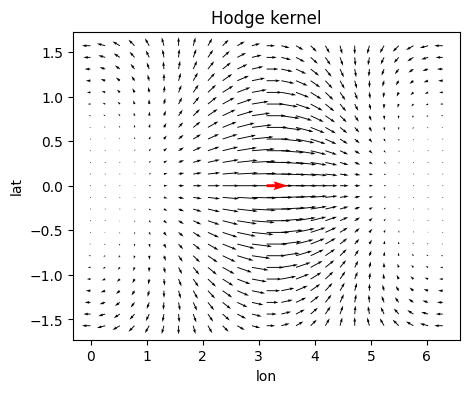

In [132]:
from matplotlib import pyplot as plt 


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
hodge_lat, hodge_lon = v_x_hodge.unbind(-1)
# hodge
ax.quiver(lon, lat, hodge_lon, hodge_lat, angles="uv")
ax.quiver([y_sph[:, 1]], [y_sph[:, 0]], v_y_sph[:, 1], v_y_sph[:, 0], angles="uv", color="red")
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.set_title("Hodge kernel")

# Fit kernel exactly

# Inducing points 